# MPLS-Kit Demonstration Notebook
This notebook provides a functional example on the capabilities of the MPLS-Kit 

In [1]:
#Load requirements

import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import jsonschema
import json
import math 
from pprint import pprint
from itertools import chain, count

from networkx.algorithms.shortest_paths.weighted import _weight_function, _dijkstra_multisource
from resource import getrusage, RUSAGE_SELF

from mpls_fwd_gen import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

/tmp/ipykernel_21693/4036432208.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


##  Choose the topology
In the next cell you can choose among three options to experiemnt with topologies: generate a random one, load one from an external file or simply define a custom topology in python.

In [2]:
# Topology configuration
topology_option = "external"   # You can free from the following options: random, external, custom.

#random_seed
random_seed = 1

# Get topology
if topology_option == "random":
    mode = "random.log_degree"   # custom, random.log_degree, random.large_degree
    n = 10                     # number of nodes, for random only
    weight_mode = "random"       # random or equal or distance
    gen_method = 1               # method for generating the random topology
    
    G = generate_topology(mode, 
                      n, 
                      weight_mode = "random", 
                      gen_method = 1, 
                      visualize = False, 
                      display_tables = False, 
                      random_seed = random_seed 
                     )

    
elif topology_option == "external":   
    G = topology_from_aalwines_json("example/abilene.json", visualize = True)

    
elif topology_option == "custom":
    G = nx.Graph()
    G.add_edge("R7", "R0", weight=1)
    G.add_edge("R0", "R1", weight=1)
    G.add_edge("R0", "R2", weight=1)
    G.add_edge("R0", "R3", weight=1)
    G.add_edge("R3", "R2", weight=1)
    G.add_edge("R2", "R4", weight=1)
    G.add_edge("R4", "R1", weight=1.5)
    G.add_edge("R1", "R5", weight=1)
    G.add_edge("R4", "R6", weight=1)
    
    
n = G.number_of_nodes() 
visualize = True if n<60 else False     # Use only with small networks
display_tables = False                  # Use only with small networks

## Demo parameters
In the next cell you Set parameter values for all MPLS protocols and features that you want deployed in the network.

In [3]:
# Generator configuration
enable_PHP = False
numeric_labels = False


## LDP
enable_LDP = False


## RSVP
enable_RSVP = True

protection = "facility-node" # options: None, "facility-node"

if topology_option == "custom":
    num_lsps = [("R7","R5"),("R7","R5"),("R0","R6")]  # Explicit tunnels to create.
else:
    num_lsps = 10           # Maximum number of LSPS to compute at random for RSVP only

tunnels_per_pair = 1    # no. of tunnels between same head / endtail with the exact same path


## VPN Services
enable_services = False
num_services = 40
PE_s_per_service = 3
CEs_per_PE = 1

## Generate MPLS forwarding rules

In [4]:
network = generate_fwd_rules(G, 
                             enable_PHP = enable_PHP, 
                             numeric_labels = numeric_labels, 
                             enable_LDP = enable_LDP, 
                             enable_RSVP = enable_RSVP,
                               num_lsps = num_lsps, 
                               tunnels_per_pair = tunnels_per_pair,
                             enable_services = enable_services, 
                               num_services = num_services, 
                               PE_s_per_service = PE_s_per_service, 
                               CEs_per_PE = CEs_per_PE,
                              random_seed = random_seed,
                             protection = protection
                      )

Computing RSVP...
num_lsps: 10
Tunnel_0: from Washington_DC to Houston
Tunnel_1: from Chicago to Atlanta
Tunnel_2: from Kansas_City to Sunnyvale
Tunnel_3: from Chicago to Denver
Tunnel_4: from Houston to New_York
Tunnel_5: from Atlanta to Indianapolis
Tunnel_6: from Chicago to Seattle
Tunnel_7: from New_York to Kansas_City
Tunnel_8: from Sunnyvale to Kansas_City
Tunnel_9: from Sunnyvale to New_York
RSVP ready (frr variant=facility-node).
building LFIB
Now building order 100
LFIB ready.
adapting priorities.
Refining LFIB
Finished.


### Visualize the topology

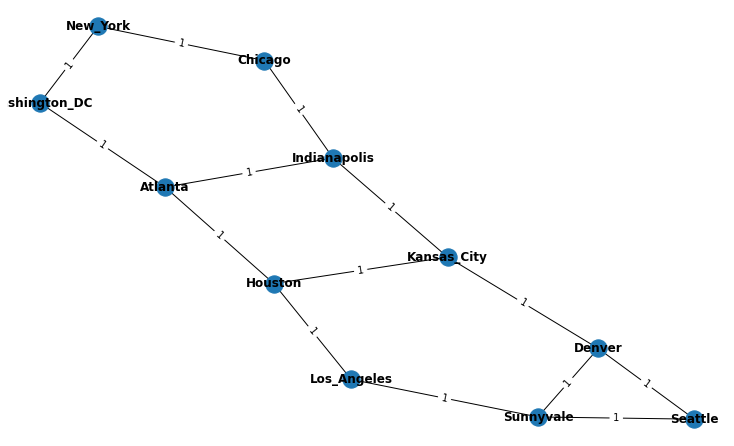

In [5]:
if visualize:
    plt.figure(3,figsize=(10,6)) 
      
    pos=nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, font_weight = 'bold')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

if display_tables:
    network.visualize()   

### Visualize LIB and LFIB tables

In [6]:
if topology_option in ["custom","random"]:
    router_list = ["R0"]
    
elif topology_option == "external":
    router_list = ["Houston"]    # change as appropiate!

network.visualize(router_list)

Number of forwarding rules in the Network:67
--------------------
Houston.LIB
('Houston', 'Atlanta', 'Washington_DC')(bypass_Houston_Atlanta_Washington_DC): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50510'}
('Houston', 'Atlanta')(bypass_Houston_Atlanta): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50511'}
('Indianapolis', 'Kansas_City')(bypass_Indianapolis_Kansas_City): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50512'}
('Indianapolis', 'Atlanta')(bypass_Indianapolis_Atlanta): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50513'}
('Indianapolis', 'Kansas_City', 'Denver')(bypass_Indianapolis_Kansas_City_Denver): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50514'}
('Atlanta', 'Houston')(bypass_Atlanta_Houston): {'owner': <mpls_fwd_gen.ProcRSVPTE object at 0x7f060552fc70>, 'local_label': '50515'}
('Atlanta', 'Indianapoli

### Inspect RSVP specific tables (if enabled)

In [7]:
r = router_list[0] # the first router from the previous cell

if enable_RSVP:
    #enable as desired to visualize different tables
    # tabl = network.routers[r].clients["RSVP-TE"].headended_lsps    # Tunnels starting at r
    # tabl = network.routers[r].clients["RSVP-TE"].requested_lsps    # Tunnels through r
    tabl = network.routers[r].clients["RSVP-TE"].requested_bypasses    # backup paths through r

    pprint(tabl)
    
if enable_services:
    tabl = network.routers[r].clients["service"].services
    pprint(tabl)


{('Atlanta', 'Houston'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7f06055328b0>,
                          'bypass_path': ['Atlanta',
                                          'Indianapolis',
                                          'Kansas_City',
                                          'Houston'],
                          'next_hop': None},
 ('Atlanta', 'Indianapolis'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7f0605532100>,
                               'bypass_path': ['Atlanta',
                                               'Houston',
                                               'Kansas_City',
                                               'Indianapolis'],
                               'next_hop': 'Kansas_City'},
 ('Houston', 'Atlanta'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7f0605532dc0>,
                          'bypass_path': ['Houston',
                                          'Kansas_City',
                                          'Indianapolis',
                      

# Simulation

### Define failure scenario
In the next cell, specify the desired failure scenario by stating explicitly the set of failed links F.

In [9]:
# Failed Scenarios
#F = []  # No failures

# other examples:
F = [("R1","R3"),("R0","R6"),("R7","R3"),("R3","R4")]
# F = [("R3","R4"),("R0","R5")]
# F = [("R3","R8"),("R0","R6"),("R0","R8")]


##########################################################################################
# Compute the graph after removing the failed sets

def filter_node(n):
    #return False if n in L else True
    return True

def filter_edge(n1,n2):
    if (n1,n2) in F or (n2,n1) in F:
        return False
    return True

view = nx.subgraph_view(network.topology, filter_node = filter_node, filter_edge = filter_edge)


## Packet tracer / Simulator

In [10]:
# Simulate the forwarding of a single packet

# change as appropiate!
if topology_option == "custom":
    init_router = "R0"
    init_stack = ["50515"]

if topology_option == "random":
    init_router = "R0"
    init_stack = ["50515"]
    
elif topology_option == "external":
    init_router = "Houston"    
    init_stack = ["50518"]

# instantiate
p = MPLS_packet(network, restricted_topology = view, init_router = init_router, init_stack = init_stack, verbose = True)

# send
p.fwd()   # prints boolean forwarding result at the end.


Current router: Houston
Current outmost label: 50518
[{'swap': '50521'}]
matching rules: 2
fwd:
[{'out': 'Atlanta', 'ops': [{'swap': '50521'}], 'priority': 0}, {'out': 'Kansas_City', 'ops': [{'swap': '50521'}, {'push': '50515'}], 'priority': 1}]
NH: Atlanta 
stack: ['50521']


Current router: Atlanta
Current outmost label: 50521
[{'swap': '50511'}]
matching rules: 2
fwd:
[{'out': 'Washington_DC', 'ops': [{'swap': '50511'}], 'priority': 0}, {'out': 'Indianapolis', 'ops': [{'swap': '50512'}, {'push': '50515'}], 'priority': 1}]
NH: Washington_DC 
stack: ['50511']


Current router: Washington_DC
Current outmost label: 50511
[{'swap': '50512'}]
matching rules: 1
fwd:
[{'out': 'New_York', 'ops': [{'swap': '50512'}], 'priority': 0}]
NH: New_York 
stack: ['50512']


Current router: New_York
Current outmost label: 50512
 FORWARDING recurrent: attempt to process next level on New_York
[{'pop': ''}]
matching rules: 1
fwd:
[{'out': 'local_lookup', 'ops': [{'pop': ''}], 'priority': 0}]
stack: []



True

## Run packets simulations for all realistic flows

In [11]:
sim = Simulator(network, trace_mode="links",  restricted_topology = view)
sim.run()

running simulation with seed 0.7522164607550114
Computing flows for simulation.


### Visualize traceroutes for all simulations.

In [12]:
print("\n\nTraces:")
sim.print_traces()



Traces:
("True;0;New_York;50511;[('New_York', 'Chicago'), ('Chicago', 'Indianapolis'), "
 "('Indianapolis', 'Kansas_City'), ('Kansas_City', None)];")
("True;0;Chicago;50512;[('Chicago', 'Indianapolis'), ('Indianapolis', "
 "'Atlanta'), ('Atlanta', None)];")
("True;0;Chicago;50513;[('Chicago', 'Indianapolis'), ('Indianapolis', "
 "'Kansas_City'), ('Kansas_City', 'Denver'), ('Denver', None)];")
("True;0;Chicago;50514;[('Chicago', 'Indianapolis'), ('Indianapolis', "
 "'Kansas_City'), ('Kansas_City', 'Denver'), ('Denver', 'Seattle'), "
 "('Seattle', None)];")
("True;0;Washington_DC;50510;[('Washington_DC', 'Atlanta'), ('Atlanta', "
 "'Houston'), ('Houston', None)];")
"True;0;Atlanta;50520;[('Atlanta', 'Indianapolis'), ('Indianapolis', None)];"
("True;0;Sunnyvale;50513;[('Sunnyvale', 'Denver'), ('Denver', 'Kansas_City'), "
 "('Kansas_City', None)];")
("True;0;Sunnyvale;50514;[('Sunnyvale', 'Los_Angeles'), ('Los_Angeles', "
 "'Houston'), ('Houston', 'Atlanta'), ('Atlanta', 'Washington_DC')

### Print results

In [13]:
success_ratio, total_flows = sim.success_rate()
print(f"""Simulation run for {total_flows} flows on failure set {F}""")
print(f"The success percentage (number of successfully forwardes packet / number of simulations) is {success_ratio*100} %")

Simulation run for 10 flows on failure set [('R1', 'R3'), ('R0', 'R6'), ('R7', 'R3'), ('R3', 'R4')]
The success percentage (number of successfully forwardes packet / number of simulations) is 100.0 %
